In [82]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop', 'dislike', 'rock', 'peace']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

PATH = '../gesture_dataset_sample'

In [83]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'{PATH}/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

In [84]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

In [85]:
  
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(f'{PATH}/{condition}')):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{PATH}/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                    label_names.append(label)
                
            label_index = label_names.index(label)
                
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [86]:
# Load my own json file
with open('annot-jonas.json') as f:
    own_annotations = json.load(f)

Here im going through each condition and saving the images and labels

In [87]:
  
own_images = [] # stores actual image data
own_labels = [] # stores labels (as integer - because this is what our network needs)
own_label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(f'./imgs/{condition}')):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'./imgs/{condition}/{filename}')
        # get annotation from the dict we loaded earlier
        try:
            annotation = own_annotations[UID]
        except Exception as e:
            print(e)
            print(f'Could not find annotation for {condition}/{UID}')
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in own_label_names:
                    own_label_names.append(label)
                
            label_index = label_names.index(label)
                
            own_images.append(preprocessed)
            own_labels.append(label_index)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [88]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [89]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

Here im creating my own X_test and y_test for later predicitons

In [90]:
own_X_test = np.array(own_images).astype('float32')
own_X_test = own_X_test / 255.

own_y_test_one_hot = to_categorical(own_labels)

own_y_test = own_labels

own_X_test = own_X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

In [91]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'leaky_relu'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

C:\Users\brede\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [92]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.1835 - loss: 1.8066 - val_accuracy: 0.1564 - val_loss: 1.8484 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.2282 - loss: 1.7790 - val_accuracy: 0.3282 - val_loss: 1.7038 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3171 - loss: 1.6665 - val_accuracy: 0.5153 - val_loss: 1.3324 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4797 - loss: 1.3251 - val_accuracy: 0.6135 - val_loss: 0.9949 - learning_rate: 0.0010
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6017 - loss: 1.0238 - val_accuracy: 0.7607 - val_loss: 0.7196 - learning_rate: 0.0010
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7534 - loss: 0.6685 - val_accuracy: 0.7975 - val_loss: 0.5093 - learning_rate: 0.0010
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8117 - loss: 0.

In [93]:
model.save('gesture_recognition.keras')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
before [[1.2445590e-10 1.8121168e-06 5.2215245e-09 9.9999821e-01 5.9681882e-12
  6.8820849e-10]
 [2.4820952e-09 5.8388398e-08 2.0073096e-10 9.0851832e-14 9.9999642e-01
  3.5149651e-06]
 [3.8105017e-04 9.9269593e-01 5.0965355e-06 6.7248191e-03 1.9089747e-04
  2.1947806e-06]
 ...
 [9.6666909e-06 1.4043018e-03 2.5721112e-05 9.9855608e-01 4.0626114e-07
  3.8214075e-06]
 [5.6435527e-09 2.2726077e-05 2.5484078e-07 9.9997699e-01 4.9583901e-09
  1.8176932e-08]
 [1.9862102e-05 5.3116554e-01 6.9981802e-06 2.2997053e-03 4.6492445e-01
  1.5834756e-03]]
probabilities [3 4 1 4 0 5 3 3 1 1 1 2 1 3 5 1 1 2 0 2 0 1 5 3 4 0 0 1 5 0 1 1 5 1 0 4 0
 5 0 3 2 1 4 0 3 2 4 5 4 5 3 3 1 1 5 3 1 4 0 0 2 5 4 4 4 1 4 2 1 2 1 3 1 1
 1 1 3 5 5 2 5 1 0 5 1 2 1 0 4 0 1 2 2 2 5 0 1 3 1 2 5 2 0 4 3 0 4 4 1 3 2
 2 1 4 1 4 2 2 1 2 4 2 4 2 0 1 1 2 3 1 5 5 3 0 0 1 1 0 1 3 3 0 0 0 2 4 4 0
 5 2 0 2 1 3 2 3 2 4 4 5 4 1 0 2 1 0 1 1 3 2 4 4 2 3 4 2 1 1 2 4 1 3 4 2 4
 3 4 5 4 1 1 1 5 4 2 2 3

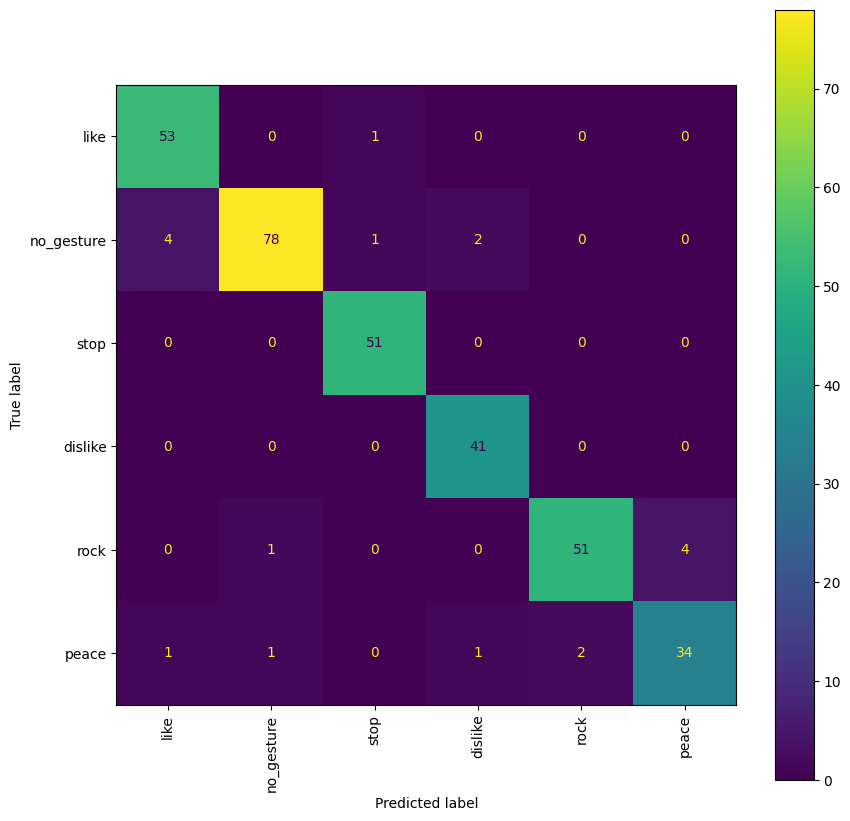

In [94]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
before [[9.99956727e-01 4.77687672e-06 2.64448645e-05 1.58350808e-08
  2.76137921e-08 1.20598634e-05]
 [8.89696360e-01 6.37796475e-03 1.03005007e-01 5.53863822e-04
  1.14842933e-05 3.55318916e-04]
 [9.99999881e-01 2.48377141e-08 8.56444160e-08 7.19214618e-12
  4.03943545e-11 2.47687861e-08]
 [4.26330444e-05 2.06889163e-04 9.91979122e-01 3.75623885e-03
  4.06424428e-04 3.60873621e-03]
 [3.04314005e-03 7.43185937e-01 1.85927331e-01 5.58973998e-02
  1.01469485e-02 1.79931207e-03]
 [1.23519190e-01 3.64993095e-01 4.38706905e-01 3.28247398e-02
  1.38292946e-02 2.61266958e-02]
 [2.38046661e-04 3.38094495e-03 1.95130601e-03 9.90609169e-01
  6.27051850e-05 3.75781860e-03]
 [1.47146005e-02 1.18479840e-01 9.54910833e-03 8.46679270e-01
  6.37237332e-04 9.93991923e-03]
 [2.17240027e-04 6.33885898e-03 1.28676288e-03 9.89587665e-01
  5.42579764e-05 2.51519191e-03]
 [3.52471034e-05 1.82562551e-04 9.32386756e-05 2.38212510e-06
  5.30745029e-01 4.68941510e-01]
 [9.8

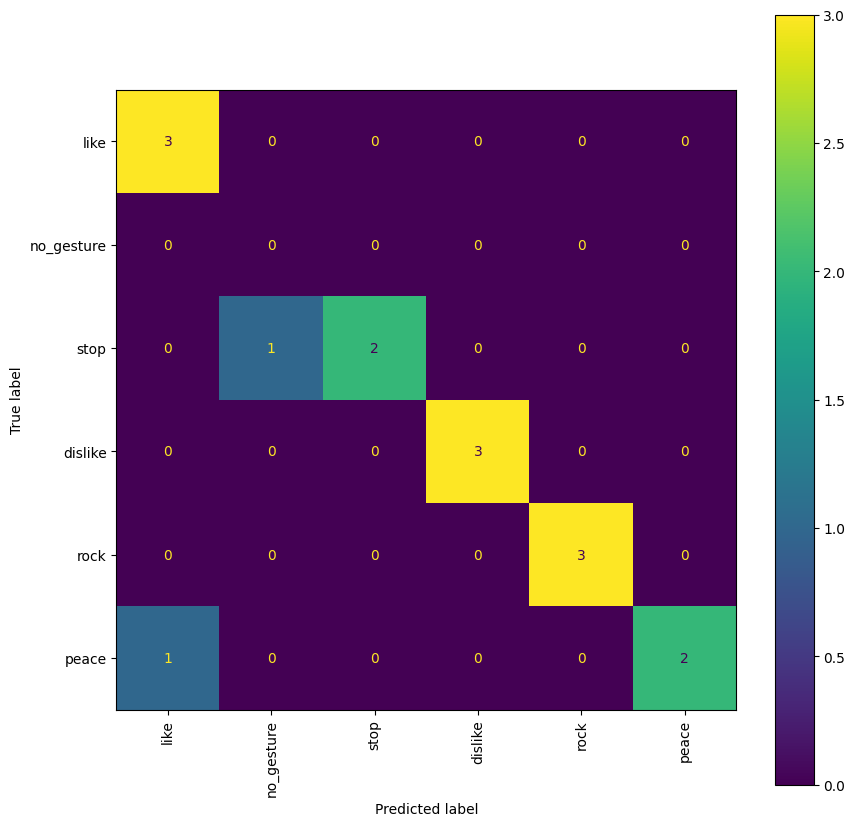

In [95]:
# let the model make predictions using our own data
y_predictions = model.predict(own_X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(own_y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass